In [1]:
%matplotlib inline
import pandas as pd
import csv as csv
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
#from sklearn import datasets, linear_model
import matplotlib
import matplotlib.pylab as pl
#from matplotlib import rcParams
#from mpl_toolkits.basemap import Basemap
#import sqlite3

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
#Loading data
ds    = pd.read_csv('../csv/train.csv', header=0, dtype={'StateHoliday':'str'})
store = pd.read_csv('../csv/store.csv', header=0)

In [3]:
len(ds)

1017209

In [4]:
ds.columns

Index([u'Store', u'DayOfWeek', u'Date', u'Sales', u'Customers', u'Open',
       u'Promo', u'StateHoliday', u'SchoolHoliday'],
      dtype='object')

In [5]:
#Dropping some stuff for simplicity, following the assignment, but still keeping some more than suggested for now
ds = ds.drop(['Promo','StateHoliday','SchoolHoliday'],axis=1)

In [6]:
ds.head()

,Store,DayOfWeek,Date,Sales,Customers,Open
0,1,5,2015-07-31,5263,555,1
1,2,5,2015-07-31,6064,625,1
2,3,5,2015-07-31,8314,821,1
3,4,5,2015-07-31,13995,1498,1
4,5,5,2015-07-31,4822,559,1


In [7]:
store.columns

Index([u'Store', u'StoreType', u'Assortment', u'CompetitionDistance',
       u'CompetitionOpenSinceMonth', u'CompetitionOpenSinceYear', u'Promo2',
       u'Promo2SinceWeek', u'Promo2SinceYear', u'PromoInterval'],
      dtype='object')

In [8]:
#Tot number of stores considered
len(store)

1115

In [9]:
store = store[['Store','CompetitionDistance','StoreType']]

In [10]:
store.head()

,Store,CompetitionDistance,StoreType
0,1,1270,c
1,2,570,a
2,3,14130,a
3,4,620,c
4,5,29910,a


In [11]:
#Merging store data
ds = pd.merge(ds,store,on='Store')

In [12]:
#Datetime
ds['Date'] = pd.to_datetime(ds['Date'])

In [13]:
ds.columns = [x.lower() for x in ds.columns]

In [14]:
ds.head()

,store,dayofweek,date,sales,customers,open,competitiondistance,storetype
0,1,5,2015-07-31,5263,555,1,1270,c
1,1,4,2015-07-30,5020,546,1,1270,c
2,1,3,2015-07-29,4782,523,1,1270,c
3,1,2,2015-07-28,5011,560,1,1270,c
4,1,1,2015-07-27,6102,612,1,1270,c


In [15]:
ds.describe()

,store,dayofweek,sales,customers,open,competitiondistance
count,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1014567.000000
mean,558.429727,3.998341,5773.818972,633.145946,0.830107,5430.085652
std,321.908651,1.997391,3849.926175,464.411734,0.375539,7715.323700
min,1.000000,1.000000,0.000000,0.000000,0.000000,20.000000
25%,280.000000,2.000000,3727.000000,405.000000,1.000000,710.000000
50%,558.000000,4.000000,5744.000000,609.000000,1.000000,2330.000000
75%,838.000000,6.000000,7856.000000,837.000000,1.000000,6890.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,75860.000000


In [16]:
len(ds.competitiondistance)

1017209

In [17]:
#Checking for NaNs (count is different for this column in describe)
len(ds[ds.competitiondistance!=ds.competitiondistance])

2642

In [18]:
#Checking for NaNs
len(ds[ds['open']!=ds['open']])

0

In [19]:
#I want to check if all the stores stay close the same days and if all are considered for the same length of time
days = ds.groupby('store').agg({
        'open':{
            'tot_days': 'count',
            'closed_days': lambda x: x.count()-x.sum()
        }
    })

In [20]:
days.head()

open            
      tot_days closed_days
store                     
1          942         161
2          942         158
3          942         163
4          942         158
5          942         163

In [21]:
days.columns = days.columns.get_level_values(1)

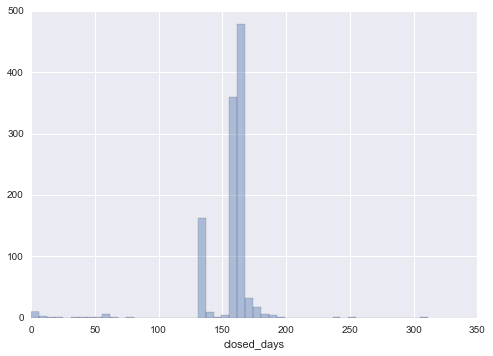

In [22]:
sns.distplot(days.closed_days,kde=False)

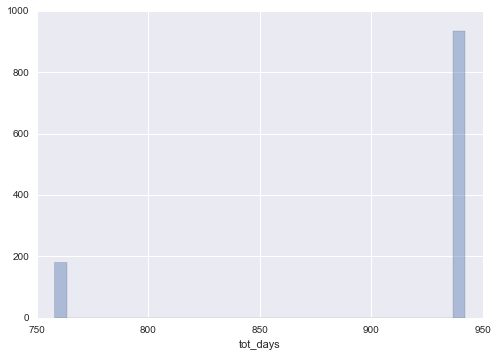

In [23]:
sns.distplot(days.tot_days,kde=False)

In [24]:
days.tot_days.unique()

array([942, 758, 941])

In [25]:
days[days.tot_days==941]

,tot_days,closed_days
store,,
988,941,157


In [26]:
len(days[days.tot_days==758])

180

It appears that 180 stores have data for about 200 days less than the others (while there is one that has data for 1 day less only).

In [27]:
short_store_id = days.ix[days.tot_days==758].index.tolist()

In [28]:
short_store = ds[ds.store.isin(short_store_id)]

In [29]:
short_store.date.apply(lambda x: (x.year,x.month)).unique()

array([(2015, 7), (2015, 6), (2015, 5), (2015, 4), (2015, 3), (2015, 2),
       (2015, 1), (2014, 6), (2014, 5), (2014, 4), (2014, 3), (2014, 2),
       (2014, 1), (2013, 12), (2013, 11), (2013, 10), (2013, 9), (2013, 8),
       (2013, 7), (2013, 6), (2013, 5), (2013, 4), (2013, 3), (2013, 2),
       (2013, 1)], dtype=object)

In [30]:
ds.date.max() - short_store.date.max()

Timedelta('0 days 00:00:00')

In [31]:
ds.date.min() - short_store.date.min()

Timedelta('0 days 00:00:00')

The stores with less days are missing data from the second half of 2014. Let's check for the one with just one day less.

In [32]:
ds[ds.store==988].date.min() - ds.date.min()

Timedelta('1 days 00:00:00')

The data for store 988 start one day later

Let's check general distributions of sales and customers

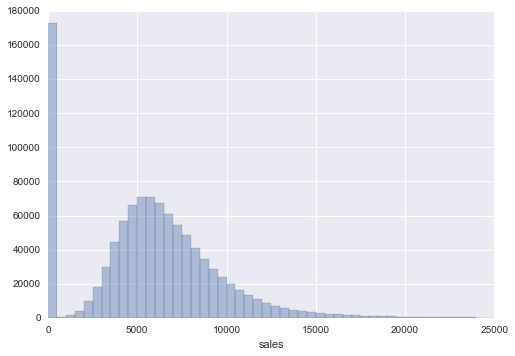

In [33]:
sns.distplot(ds.sales, kde=False, hist_kws={'range': [0,25000]})

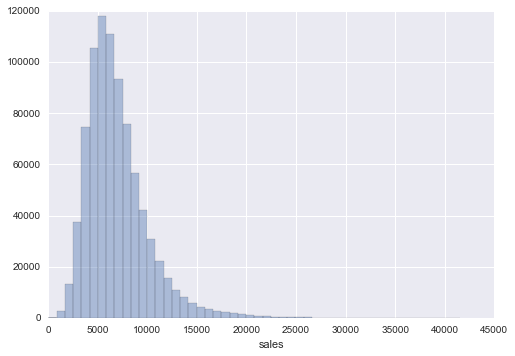

In [34]:
#screening for days with no sale (presumibly days when the stores were closed)
sns.distplot(ds[ds.sales!=0].sales, kde=False)

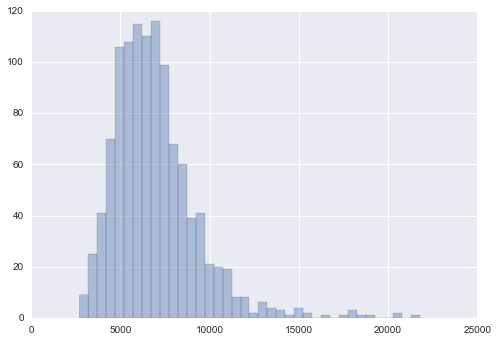

In [35]:
#Distribution of average sales per store, computed on days when store was open
sns.distplot(ds.groupby('store').aggregate({'sales':lambda y: np.mean([x for x in y if x!=0])}),kde=False)

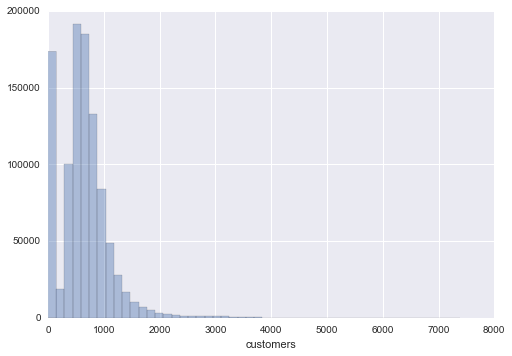

In [36]:
sns.distplot(ds.customers,kde=False)

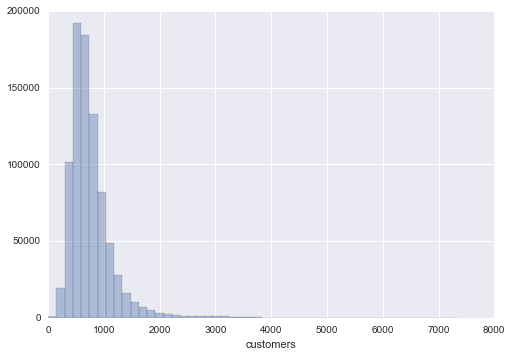

In [37]:
#screening for days with no customers (as checked above those are also days with no sales)
sns.distplot(ds[ds.customers!=0].customers, kde=False)

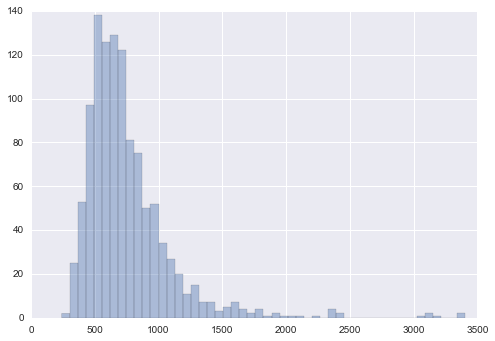

In [38]:
#Distribution of average number of customers per store, computed on days when store was open
sns.distplot(ds.groupby('store').aggregate({'customers':lambda y: np.mean([x for x in y if x!=0])}),kde=False)

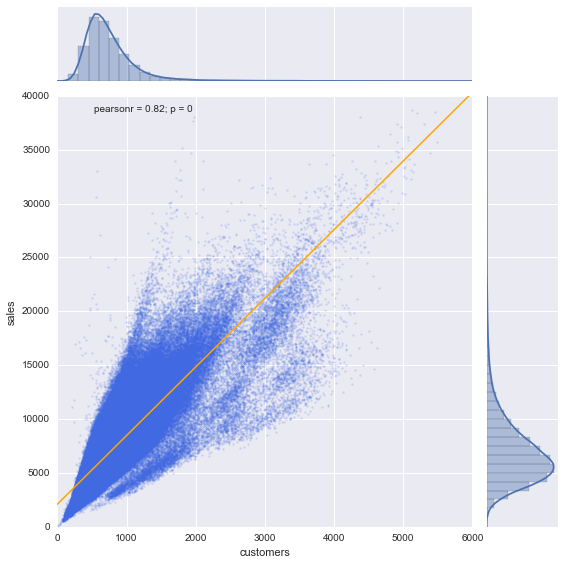

In [39]:
#Checking correlation between # of customers and sales
#ds_sample = ds[ds.sales!=0].sample(1000)
sns.jointplot(x='customers',y='sales',data=ds[ds.sales!=0],
              scatter_kws={'s':5,'alpha':0.2,'color':'royalblue'},
              line_kws={'color':'orange','lw':1.5},
              kind='reg',
              size=8,
              xlim=(0,6000),
              ylim=(0,40000),
              ci=None,  
           )

In [40]:
store_avg = ds.groupby('store').agg({
        'customers':{'avg_cust': lambda y: np.mean([x for x in y if x!=0])},
        'sales':{'avg_sales': lambda y: np.mean([x for x in y if x!=0])}
    })
store_avg.columns = store_avg.columns.get_level_values(1)

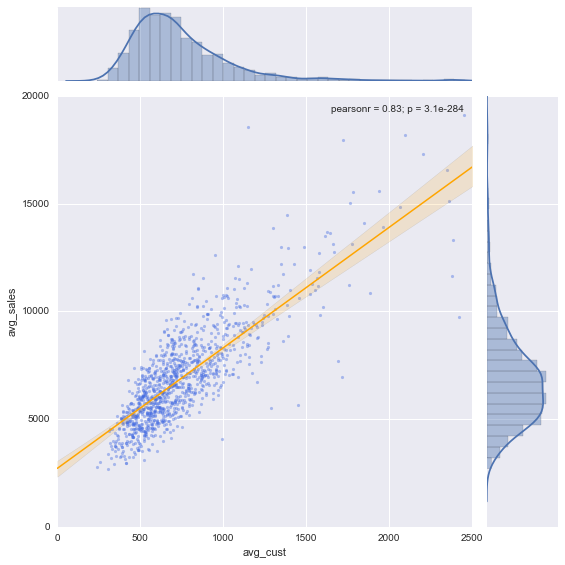

In [41]:
#Checking correlation between avg in different stores
sns.jointplot(x='avg_cust',y='avg_sales',data=store_avg,
              scatter_kws={'s':10,'alpha':0.4,'color':'royalblue'},
              line_kws={'color':'orange','lw':1.5},
              kind='reg',
              size=8,
              xlim=(0,2500),
              ylim=(0,20000)
           )

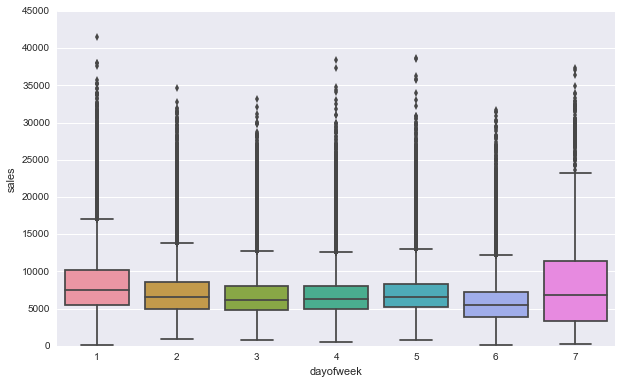

In [42]:
#Change in sale as day of the week
#ds_sample = ds[ds.sales!=0].sample(10000)
g = sns.boxplot(y='sales',x='dayofweek',data=ds[(ds.sales!=0)])#_sample)
g.figure.set_size_inches(10,6)

The average sales per store seem a little higher for the ones that are open on Sunday, but the variance is also higher. It is not clear whether it is profitable to keep the store open on Sundays or not just based on this.

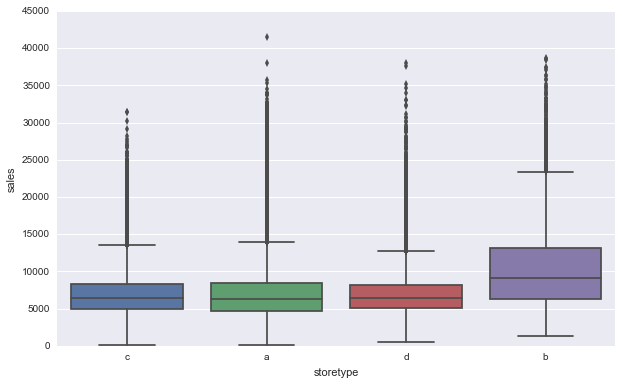

In [43]:
#Change in sale as type of store
#ds_sample = ds[ds.sales!=0].sample(10000)
g = sns.boxplot(y='sales',x='storetype',data=ds[(ds.sales!=0)])#_sample)
g.figure.set_size_inches(10,6)

Store type b seems clearly more profitable than any other type.

In [44]:
ds.ix[ds.sales>40000,'store'].nunique()

1

In [45]:
ds[ds.sales>40000] #this might be an outlier

,store,dayofweek,date,sales,customers,open,competitiondistance,storetype
827591,909,1,2015-06-22,41551,1721,1,1680,a


In [46]:
len(ds.loc[(ds.sales==0) & (ds.open==1),'store'])

54

In [47]:
len(ds[(ds.sales==0) & (ds.open==1)])

54

In [48]:
len(ds.loc[(ds.customers==0) & (ds.open==1)])

52

In [49]:
len(ds.loc[(ds.customers==0) & (ds.open==1),'store'].isin(ds.loc[(ds.sales==0) & (ds.open==1),'store']))

52

Some stores are reported open even if they had no customers or no sales. Luckily there have not been sales in the "open" days with no customer, whereas two stores were open with customers and no sales. This unfortunate event of no sales on an open day happened only once per store. Let's see which stores had zero sales but non zero customers.

In [50]:
ds[(ds.sales==0) & (ds.open==1) & (ds.customers!=0)]

,store,dayofweek,date,sales,customers,open,competitiondistance,storetype
864013,948,4,2013-04-25,0,5,1,1430,b
1003331,1100,2,2014-04-29,0,3,1,540,a


I think one could safely assume that the the stores with no customers and no sales were probably closed, not sure what to think about these two instances. Although, it might just be that they are in "remote" locations and do not get many customers generally, let's check for that.

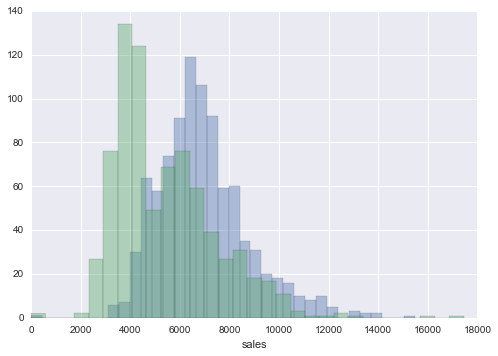

In [51]:
#Stores 948 and 1100 has a day with no sales but customers, checking if generally it has low sales
sns.distplot(ds.loc[(ds.store==948)&(ds.open==1),'sales'],kde=False)
sns.distplot(ds.loc[(ds.store==1100)&(ds.open==1),'sales'],kde=0)

Probably a fluke

In [52]:
#These are the stores with open day and no customers, let's check if they generally have low customers number
#Some have it double (like store 25) as one can check from the length of the array
ds.loc[(ds.customers==0) & (ds.open==1),'store'].unique()

array([  25,   28,   57,  102,  227,  232,  238,  259,  303,  327,  339,
        353,  357,  364,  387,  391,  548,  589,  623,  661,  663,  665,
        674,  681,  699,  700,  708,  762,  835,  850,  882,  887,  925,
        927,  971,  983,  986, 1017, 1039, 1100])

In [53]:
ds.loc[ds.store==925,'customers'].describe()

count     942.000000
mean      978.699575
std       527.315907
min         0.000000
25%       904.500000
50%      1098.500000
75%      1270.000000
max      2795.000000
Name: customers, dtype: float64

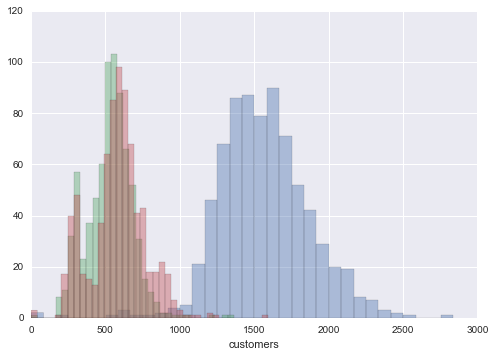

In [54]:
sns.distplot(ds.loc[(ds.store==25)&(ds.open==1),'customers'],kde=False)
sns.distplot(ds.loc[(ds.store==700)&(ds.open==1),'customers'],kde=0)
sns.distplot(ds.loc[(ds.store==28)&(ds.open==1),'customers'],kde=0)

Probably flukes, especially for big stores like 25 (blue in the figure)

In [55]:
#Let's check the competition distance
competition = ds.groupby(['store','storetype','competitiondistance']).agg({
        'customers': lambda y: np.mean([x for x in y if x!=0]),
        'sales': lambda y: np.mean([x for x in y if x!=0])
    }).reset_index()

In [56]:
competition.head()

,store,storetype,competitiondistance,customers,sales
0,1,c,1270,564.049936,4759.096031
1,2,a,570,583.998724,4953.900510
2,3,a,14130,750.077022,6942.568678
3,4,c,620,1321.752551,9638.401786
4,5,a,29910,537.340180,4676.274711


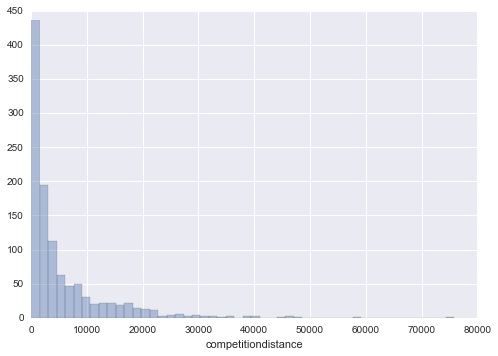

In [57]:
sns.distplot(competition.competitiondistance,kde=False)

In [58]:
competition['logdist'] = np.log(competition.competitiondistance)
competition['logsale'] = np.log(competition.sales)
competition['logcust'] = np.log(competition.customers)

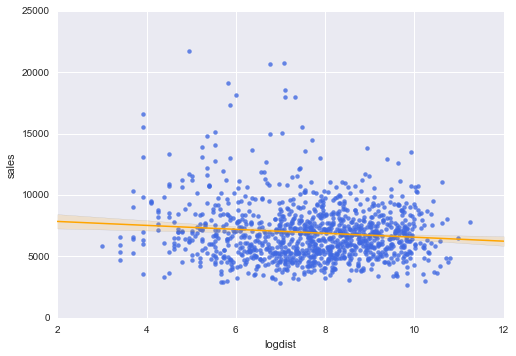

In [59]:
sns.regplot(x='logdist',y='sales',data=competition,
            scatter_kws={'s':20,'alpha':0.8,'color':'royalblue'},
            line_kws={'color':'orange','lw':1.5}
           )

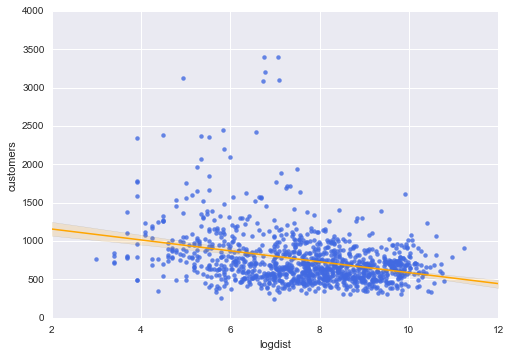

In [60]:
sns.regplot(x='logdist',y='customers',data=competition,
            scatter_kws={'s':20,'alpha':0.8,'color':'royalblue'},
            line_kws={'color':'orange','lw':1.5}
           )

The log of the distance seems the right variable to use here, rather than simply the distance: there is a difference whether I choose to take a car or not to go to another store, but then 100-200 meters by foot is as acceptable as 1-2km by car.

Perhaps surprisingly, there is a small negative correlation between distance and customers (less accentuated but still present in the sales). The reason for this probably resides in the fact that the stores that get the most customers are situated in highly densely populated areas, where there are a lot of stores (and competition) around.

In [61]:
# I want to check how many stores are open on sundays
ds.loc[(ds.dayofweek==7)&(ds.open==1),'store'].nunique()

33

In [62]:
ds.loc[(ds.dayofweek==7)&(ds.open==1),'store'].value_counts()

85      134
262     134
1097    134
494     134
335     134
769     134
733     134
682     134
562     134
423     134
259     133
353     133
274     133
948     132
676     131
1081    108
512     106
578     106
530     106
310     102
1099     96
453      92
863      92
122      90
732      88
1045     88
209      87
299      86
524      86
867      85
931      80
433      71
877      22
Name: store, dtype: int64

Only 33 stores have been open on Sunday and only 10 have been open every Sunday.

The first day of the set is January first, so chances are that stores are closed. Let's check how many made a sale on the first day of data collecting

In [63]:
firstday = ds.date.min()
len(ds[(ds.date==firstday)&(ds.sales!=0)])

17

As expected most of the stores did not make money (were closed) on the first day of the dataset. Maybe it is best to exclude this day in the analysis.